In [3]:
import numpy as np
import tensorflow as tf
import matplotlib as mpl
import matplotlib.pyplot as plt

import keras
from keras.models import Sequential
from keras.layers import Dense, Dropout, Activation, Input, Flatten
from keras.regularizers import l2

# Loading hand writing dataset

In [4]:
def exract_two_classes( data, labels, classes=(0,1), no_instance=400):
    data_zeroes = data[ np.argwhere( labels ==  classes[0] ).reshape( -1 ) ][ :no_instance ]
    data_ones = data[ np.argwhere( labels == classes[1] ).reshape( -1 ) ][ :no_instance ]
    x = np.vstack( (data_zeroes, data_ones) )
    
    # normalize the data
    x = x / 255.

    labels_zeroes = np.zeros( data_zeroes.shape[ 0 ] )
    labels_ones = np.ones( data_ones.shape[ 0 ] )
    y = np.append( labels_zeroes, labels_ones )

    return x, y

In [5]:
mnist = tf.keras.datasets.fashion_mnist # Object of the MNIST dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data() # Load data

# extract ones and zeroes
x_train, y_train = exract_two_classes( x_train, y_train )
x_test, y_test = exract_two_classes( x_test, y_test )

In [6]:
x_train = np.array(x_train).astype("float")
y_train = np.array(y_train).astype("float")
x_test = np.array(x_test).astype("float")
y_test = np.array(y_test).astype("float")

In [7]:
print("Lengh of dimensions for x_train: ", x_train.shape)
print("Lengh of dimensions for y_train: ", y_train.shape)
print("Lengh of dimensions for x_test: ", x_test.shape)
print("Lengh of dimensions for y_test: ", y_test.shape)

Lengh of dimensions for x_train:  (800, 28, 28)
Lengh of dimensions for y_train:  (800,)
Lengh of dimensions for x_test:  (800, 28, 28)
Lengh of dimensions for y_test:  (800,)


In [8]:
'''reshape'''
x_train = x_train.reshape(-1,28,28,1)
x_test = x_test.reshape(-1,28,28,1)

In [9]:
'''Normalization'''
#x_train = x_train / 255.0
#y_train = y_train / 255.0

'Normalization'

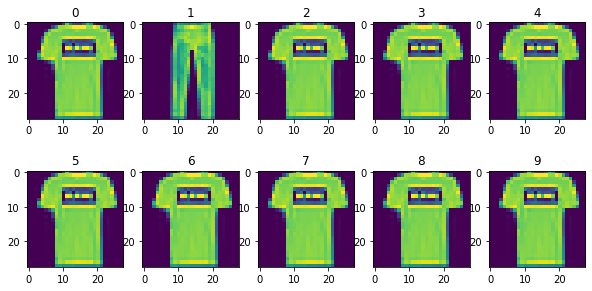

In [10]:
n_classes = 10
inds=np.array([y_train==i for i in range(n_classes)])
f,ax=plt.subplots(2,5,figsize=(10,5))
ax=ax.flatten()
for i in range(n_classes):
    ax[i].imshow(x_train[np.argmax(inds[i])].reshape(28,28))
    ax[i].set_title(str(i))
plt.show()

# Simple fully-connected neural network with 2 hidden layers

In [11]:
np.random.seed(44)
model = tf.keras.Sequential([
    # 1st convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu', input_shape=(28,28,1)),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # 2nd convolution
    tf.keras.layers.Conv2D(filters=20, kernel_size=(3,3), activation='relu'),
    tf.keras.layers.MaxPool2D(pool_size=(2,2), strides=None, padding='valid'),
    # dense
    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(500, activation='relu'),
    tf.keras.layers.Dense(10, activation='softmax') 
])

model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 26, 26, 20)        200       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 13, 13, 20)        0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 11, 11, 20)        3620      
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 5, 5, 20)          0         
_________________________________________________________________
flatten (Flatten)            (None, 500)               0         
_________________________________________________________________
dense (Dense)                (None, 500)               250500    
_________________________________________________________________
dense_1 (Dense)              (None, 10)                5

In [12]:
'''Traning the model'''
history = model.fit(x_train, y_train, epochs=5, verbose=1,
                    validation_data=(x_test, y_test))

#(train_x, train_y, epochs=5,validation_data=(valid_x, valid_y))

Epoch 1/5
25/25 [==============================] - 1s 42ms/step - loss: 1.2320 - accuracy: 0.7136 - val_loss: 0.1546 - val_accuracy: 0.9475
Epoch 2/5
25/25 [==============================] - 0s 16ms/step - loss: 0.1362 - accuracy: 0.9485 - val_loss: 0.0892 - val_accuracy: 0.9650
Epoch 3/5
25/25 [==============================] - 0s 14ms/step - loss: 0.0863 - accuracy: 0.9704 - val_loss: 0.0656 - val_accuracy: 0.9725
Epoch 4/5
25/25 [==============================] - 0s 14ms/step - loss: 0.0640 - accuracy: 0.9767 - val_loss: 0.0731 - val_accuracy: 0.9812
Epoch 5/5
25/25 [==============================] - 0s 17ms/step - loss: 0.0562 - accuracy: 0.9798 - val_loss: 0.0612 - val_accuracy: 0.9750


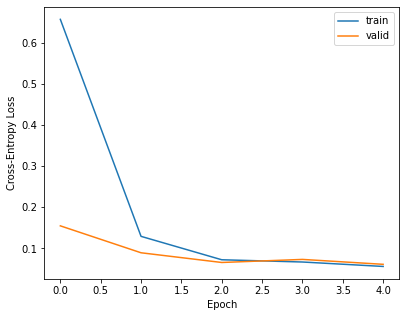

In [13]:
'''Plot loss trajectory throughout training'''
plt.figure(1, figsize=(14,5))
plt.subplot(1,2,1)
plt.plot(history.history['loss'], label='train')
plt.plot(history.history['val_loss'], label='valid')
plt.xlabel('Epoch')
plt.ylabel('Cross-Entropy Loss')
plt.legend()

In [14]:
score = model.evaluate(x_test, y_test, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

Test cross-entropy loss: 0.06118
Test accuracy: 0.98


# FGSM

In [15]:
import numpy as np
import tensorflow as tf
#import tensorflow_datasets as tfds
from absl import app, flags
from easydict import EasyDict
from tensorflow.keras import Model
from tensorflow.keras.layers import Dense, Dropout, Flatten, Conv2D

from cleverhans.tf2.attacks.projected_gradient_descent import projected_gradient_descent
from cleverhans.tf2.attacks.fast_gradient_method import fast_gradient_method

In [16]:
original_image = x_test
original_image = tf.convert_to_tensor(original_image.reshape((800,28,28,1)))

original_label = y_test
original_label = np.reshape(original_label, (800,)).astype('int64') 

In [17]:
logits_model = tf.keras.Model(model.input,model.layers[-1].output)

In [18]:
x_test[1,:,:,:].dtype

dtype('float64')

# epsilon = 0.06

In [19]:
epsilon  = 0.06
adv_fgsm_x = fast_gradient_method(logits_model, original_image, epsilon, norm=np.inf, targeted=False)

In [20]:
epsilon  = 0.06
adv_fgsm_x2 = fast_gradient_method(logits_model, original_image, epsilon, norm=2, targeted=False)

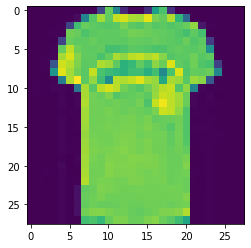

Test cross-entropy loss: 0.24905
Test accuracy: 0.89


In [21]:
plt.figure()
plt.imshow(adv_fgsm_x2[0])  
plt.show()
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, original_label, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

In [22]:
adv_fgsm_x.shape

TensorShape([800, 28, 28, 1])

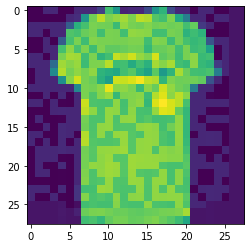

Test cross-entropy loss: 0.24905
Test accuracy: 0.89


In [23]:
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, original_label, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

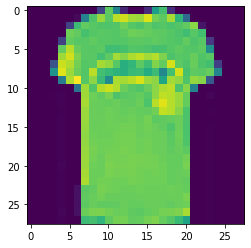

Test cross-entropy loss: 0.06118
Test accuracy: 0.98


In [24]:
plt.figure()
plt.imshow(x_test[0])  
plt.show()
'''Score on original data'''
score = model.evaluate(x_test, original_label, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

# epsilon = 0.2

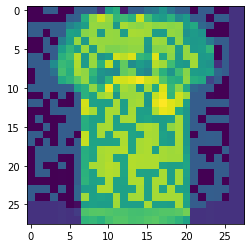

Test cross-entropy loss: 2.52845
Test accuracy: 0.15


In [25]:
epsilon  = 0.2
adv_fgsm_x = fast_gradient_method(logits_model, original_image, epsilon, norm=np.inf, targeted=False)
plt.figure()
plt.imshow(adv_fgsm_x[0])  
plt.show()
'''Score on adversarial examples'''
score = model.evaluate(adv_fgsm_x, original_label, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])

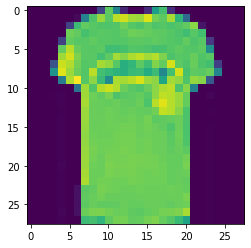

Test cross-entropy loss: 0.06118
Test accuracy: 0.98


In [26]:
plt.figure()
plt.imshow(x_test[0])  
plt.show()
'''Score on adversarial examples'''
score = model.evaluate(x_test, original_label, verbose=0)
print('Test cross-entropy loss: %0.5f' % score[0])
print('Test accuracy: %0.2f' % score[1])